In [1]:
import numpy as np
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from time import perf_counter
import gensim
import math
import pprint
from collections import defaultdict
from numba import jit
import warnings
import pickle
import torch
import utils
import torch.nn as nn
import torch.nn.functional as F
from MatrixFactorization import Factorizer
import MatrixFactorization
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from bayes_opt import BayesianOptimization,UtilityFunction
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

In [3]:
class DNN(nn.Module):
    def __init__(self,layer_size,drop1,drop2,drop3):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(50, layer_size)
        self.fc2 = nn.Linear(layer_size, layer_size)
        self.fc3 = nn.Linear(layer_size, layer_size)
        self.fc4 = nn.Linear(layer_size, layer_size)
        self.fc5 = nn.Linear(layer_size, layer_size)
        self.fc6 = nn.Linear(layer_size, layer_size)
        self.fc7 = nn.Linear(layer_size+10, 1)
        self.out_act = nn.Sigmoid()
        self.drop1 = drop1
        self.drop2 = drop2
        self.drop3 = drop3
        genres_results=pd.read_csv('./data/genresLsiResult.csv')
        genres_results=genres_results.to_numpy()
        genres_result=[[eval(results[x]) if not pd.isnull(results[x]) else np.nan for x in range(1,len(results))] for results in genres_results]
#         print(genres_result[0][0][1])
        genres_result= [[x[1] if not pd.isnull(x) else np.nan for x in j] for j in genres_result]
        self.categories_embeddings=genres_result
        genres_results=genres_result = None
        del genres_results,genres_result
        tags_titles =  self.load_obj('tagsTitleResults')
        self.tags_titles_embeddings =[[x[1] if not pd.isnull(x) else np.nan for x in j] for j in tags_titles] 
        self.tags_titles_dict = self.load_obj('tagsTitleDict')
        self.data = pd.read_csv('./data/mergedData.csv')[['moviePubYear','movieId']].drop_duplicates()
        years = [year for year in self.data['moviePubYear'] if year!=9999 ]
        N = len(np.unique(years))
        max_year = max(years)
        min_year = min(years)
        self.years = [bin(self.create_bin_year(year,years,N,max_year,min_year))[2:] for year in self.data['moviePubYear']]
        self.years = [[int(c) for c in s]for s in self.years]
        self.years_ids = self.data['movieId']
        years = N = max_year = min_year = None
        del years , N , max_year , min_year
#         self.data = None
#         del self.data
        
    def load_obj(self,name):
        with open('./data/' + name + '.pkl', 'rb') as f:
            return pickle.load(f)
        
    def create_bin_year(self,num,years,N,max_year,min_year):
        # N: number of intervals (bins)
        width = (max_year-min_year)/(1.322*math.log(N))
        return (math.floor((num-min_year)/width))
    
    def predict_user_item(self,userId,itemId):
        return
    
    def recommend(self,userId):
        return
    
    def forward(self, x,xw):
        x = self.fc1(x)
        x = torch.tanh(x)
        x = F.dropout(x,self.drop1)
        x = self.fc2(x)
        x = torch.tanh(x)
        x = F.dropout(x,self.drop2)
        x = self.fc3(x)
        x = torch.tanh(x)
        x = F.dropout(x,self.drop3)
        x = self.fc4(x)
        x = torch.tanh(x)
        x = F.dropout(x,self.drop3)
        x = self.fc5(x)
        x = torch.cat([x,xw],1)
        x = torch.tanh(x)
        x = F.dropout(x,self.drop3)
        x = self.fc7(x)
        output = self.out_act(x)
        
        return output
    
    def zero_pad(self,size):
        return [np.append(np.zeros(10-len(x)),x) if x!=np.nan else np.ones(10) for x in self.years]

In [4]:
def get_item_features(movieId,tags_title_doc_lsi,genres_doc_lsi,tags_title_dict,movies):
    con = []
#     try:
    tag_lsi = [eval(x)[1] if not pd.isnull(x) else 0  for x in (tags_title_doc_lsi.values[sorted(tags_title_dict).index(movieId)])]
    genres_lsi = [eval(x)[1] if not pd.isnull(x) else 0 for x in (genres_doc_lsi.values[movies[movies['movieId']==movieId].index[0]])]
    con = np.append(tag_lsi,genres_lsi)
#         print(len(con))
#     except:
#         print("movieId error")
#         print((tags_title_doc_lsi.values[sorted(tags_title_dict).index(movieId)]))
#         print((genres_doc_lsi.values[movies[movies['movieId']==movieId].index[0]]))
    return con
tags_title_doc_lsi=pd.read_csv('./data/tagsTitleLsiResult.csv',index_col=[0])
genres_doc_lsi=pd.read_csv('./data/genresLsiResult.csv',index_col=[0])


In [5]:
factorizer = Factorizer(20,20,0.001,0.005,True,True)
factorizer.lam = 0.0
factorizer.rank = 10

loaded matrix in %d seconds 163.3743115000001


D:\desktop\ml\recommender-system\src\MatrixFactorization.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.mat = self.mat_df.as_matrix()


In [6]:
ratings = pd.read_csv('data/ratings.csv')
movies = pd.read_csv('data/movies.csv')

In [7]:
def create_df():
    person_c = CategoricalDtype(sorted(ratings.userId.unique()), ordered=True)
    thing_c = CategoricalDtype(sorted(ratings.movieId.unique()), ordered=True)

    row = ratings.userId.astype(person_c).cat.codes
    col = ratings.movieId.astype(thing_c).cat.codes
    sparse_matrix = csr_matrix((ratings["rating"], (row, col)), \
                               shape=(person_c.categories.size, thing_c.categories.size))
    # sparse_matrix.todense()

    dfs = pd.SparseDataFrame(sparse_matrix, \
                             index=person_c.categories, \
                             columns=thing_c.categories, \
                             default_fill_value=0)
    return dfs,sparse_matrix

In [13]:
mat_df,s_matrix=create_df()


In [9]:
factorizer.maxIter = 2
start = perf_counter()
pred , errors,U,V = MatrixFactorization.ALS_full(factorizer.mat_demeaned,factorizer.rank,factorizer.lam,factorizer.maxIter)
end =perf_counter()
print("in ",end-start," seconds")

D:\desktop\ml\recommender-system\src\MatrixFactorization.py:77: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  U = np.linalg.solve(np.dot(V, V.T) + reg_term * np.eye(K), np.dot(V , ratings.T - B.T - C.T)).T
D:\desktop\ml\recommender-system\src\MatrixFactorization.py:77: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  U = np.linalg.solve(np.dot(V, V.T) + reg_term * np.eye(K), np.dot(V , ratings.T - B.T - C.T)).T
D:\desktop\ml\recommender-system\src\MatrixFactorization.py:87: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  predictor = np.dot(U,V) + B + C


Iteration -  1  Error -  5.719444937375876e-13
in  229.45548200000007  seconds


In [10]:
scaler = MinMaxScaler()
scaler.fit(V.T)
V_s_t = scaler.transform(V.T)
scaler.fit(U)
U_s = scaler.transform(U)

In [11]:
users = len(U)

In [12]:
mat_df.shape

NameError: name 'mat_df' is not defined

In [14]:
# DNN.cuda(device="cpu")

def train(scheduler,opt,Net,epochs = 1,alpha = 0.001,layer_size=50,batch_size = 50,random_factor = 10,use_saved=False,drop1=0.5,drop2=0.2,drop3=0.2):
    losses = []
    recoms = []
    targets = []
    results = []
    batch_input = []
    batch_w = []
    if(use_saved):
        Net = DNN(layer_size,drop1,drop2,drop3)
        Net.years=Net.zero_pad(10)
        Net.mat_df = pd.io.parsers.read_csv('./data/matrix_small.csv',index_col=[0]).fillna(0)
        Net.load_state_dict(torch.load('./data/DNN.pt'))
    loss_fn = nn.BCELoss()
    alpha_decay = 0
    decay_counter = 0
    Net.train()
    Net.categories_embeddings=np.nan_to_num(Net.categories_embeddings)
    scaler.fit(Net.categories_embeddings)
    Net.categories_embeddings = scaler.transform(Net.categories_embeddings)
#     Net.categories_embeddings = scaler.transform(Net.categories_embeddings)
#     Net.categories_embeddings = normalize(Net.categories_embeddings, axis=1, norm='l2')

#     print(Net.tags_titles_embeddings)
#     print(Net.tags_titles_embeddings[0])
#     return
    for e in range(epochs):
        u = 0
        b = 0
        for user_index in range(int(0.8*users)):
    #         if(u==8000):
    #             break
            start = perf_counter()
            user_id = factorizer.mat_df.index[user_index]
            collaborative_embeddings,item_ids=MatrixFactorization.recommend_embeddings(user_index,U_s,V_s_t,factorizer.mat_df,factorizer.rank,random_factor)
            utils.shuffle_unision(collaborative_embeddings,item_ids)
            collaborative_embeddings = np.nan_to_num(collaborative_embeddings)
            collaborative_embeddings,item_ids=collaborative_embeddings[0:5],item_ids[0:5]

            user_em = U[user_index]

            for i in range(len(item_ids)):
                item_id = item_ids[i]
                col_em = collaborative_embeddings[i]
                cat_id = movies[movies['movieId']==item_id].index[0]
                cat_em = Net.categories_embeddings[cat_id]
                year_id = Net.data[Net.data['movieId']==item_id].values[0][0]
           
                year_em = Net.years[year_id]
           
                nn_input = []
                w_input = []
                nn_input.extend(col_em)
                nn_input.extend(user_em)
                side_features=get_item_features(item_id,tags_title_doc_lsi,genres_doc_lsi,Net.tags_titles_dict,movies)

                w_input.extend(year_em)

                nn_input.extend(side_features)

                if(len(nn_input)+len(w_input)==60):
        

                             
                    target = [1] if mat_df[item_id][user_id]>=3 else [0]

            

                    targets.append(target)

                    batch_input.append(nn_input)
                    batch_w.append(w_input)
       
                else:
                    print("Unacceptable input size of ",len(nn_input))
                    print(item_id)

            if(b%batch_size==batch_size-1):
                start = perf_counter()
                utils.shuffle_unision(batch_input,targets)

                batch_input = torch.Tensor(batch_input)
                batch_w = torch.Tensor(batch_w)
                
                targets_t = torch.Tensor(targets)
                opt.zero_grad()
                result = Net(batch_input,batch_w)
                
                results.append(result.tolist())

                loss = loss_fn(result,targets_t)
                loss.backward()
                opt.step()
                with open("preds.txt","a") as f:
                    for t in result:
                        f.write(str(t.tolist()[0]))
                        f.write(", ")
                    f.write("\n")
                    f.write(str(loss.data))
                    f.write("\n\n")
                end = perf_counter()
                losses.append(loss.data.numpy())
                
                b=0
                targets = []
                results = []
                batch_input = []
                batch_w = []
                decay_counter += 1
            else:
                b +=1
           
            end = perf_counter()
            u +=1
    
    torch.save(Net.state_dict(),'./data/DNN.pt')
    plt.savefig("data/"+str(epochs)+str(alpha)+str(layer_size)+str(batch_size)+str(random_factor)+str(drop1)+str(drop2)+str(drop3)+".png")
    return losses

In [15]:
def test(Net,epochs = 1,layer_size=50,batch_size = 50,random_factor = 10):
    losses = []
    recoms = []
    targets = []
    results = []
    batch_input = []
    batch_w =[]
    Net.eval()
    alpha_decay = 0
    decay_counter = 0
    Net.categories_embeddings=np.nan_to_num(Net.categories_embeddings)
    scaler.fit(Net.categories_embeddings)
    Net.categories_embeddings = scaler.transform(Net.categories_embeddings)

    loss_fn = nn.BCELoss()
    for e in range(epochs):
        u = 0
        b = 0
        for user_index in range(int(users*0.8),users):
   
            start = perf_counter()
            user_id = factorizer.mat_df.index[user_index]
            collaborative_embeddings,item_ids=MatrixFactorization.recommend_embeddings(user_index,U_s,V_s_t,factorizer.mat_df,factorizer.rank,random_factor)
            utils.shuffle_unision(collaborative_embeddings,item_ids)

            collaborative_embeddings,item_ids=collaborative_embeddings[0:5],item_ids[0:5]
    
            user_em = U[user_index]
            for i in range(len(item_ids)):
                item_id = item_ids[i]
                col_em = collaborative_embeddings[i]
                cat_id = movies[movies['movieId']==item_id].index[0]
                cat_em = Net.categories_embeddings[cat_id]
                
                year_id = Net.data[Net.data['movieId']==item_id].values[0][0]

                year_em = Net.years[year_id]
            
                nn_input = []
                w_input = []
                nn_input.extend(col_em)
                nn_input.extend(user_em)
                side_features=get_item_features(item_id,tags_title_doc_lsi,genres_doc_lsi,Net.tags_titles_dict,movies).tolist()

                w_input.extend(year_em)

                nn_input.extend(side_features)

                if(len(nn_input)+len(w_input)==60):

                            
                    target = [1] if mat_df[item_id][user_id]>=3 else [0]

                    targets.append(target)

                    batch_input.append(nn_input)
                    batch_w.append(w_input)
                else:
                    print("Unacceptable input size of ",len(nn_input))
                    print(cat_id)

            if(b%batch_size==batch_size-1):
                
                with torch.no_grad():
                    start = perf_counter()
                    batch_input = torch.Tensor(batch_input)
                    batch_w = torch.Tensor(batch_w)
                    targets_t = torch.Tensor(targets)
                    utils.shuffle_unision(batch_input,targets_t)
                    result = Net(batch_input,batch_w)
                    
                    results.append(result.tolist())
                    recoms.append(result)

                    loss = loss_fn(result,targets_t)

                    end = perf_counter()

                    losses.append(loss.data.numpy())
                    with open("test_preds.txt","a") as f:
                        for t in result:
                            f.write(str(t.tolist()[0]))
                            f.write(", ")
                        f.write("\n")
                        f.write(str(loss.data))
                        f.write("\n\n")
                    b=0
                    recoms = []
                    targets = []
                    results = []
                    batch_input = []
                    batch_w = []
                    decay_counter += 1
            else:
                b +=1

            end = perf_counter()
            u +=1
    return losses

In [38]:
Net = DNN(100,0.2,0.2,0)
Net.years=Net.zero_pad(10)
# Net.mat_df = pd.io.parsers.read_csv('./data/matrix_small.csv',index_col=[0]).fillna(0)

In [39]:
Net.mat_df = pd.io.parsers.read_csv('./data/matrix_dense.csv',index_col=[0]).fillna(0)

In [46]:
opt = torch.optim.Adam(Net.parameters(),lr=0.003)
# scheduler = torch.optim.lr_scheduler.CyclicLR(opt, base_lr=0.0001, max_lr=0.1,step_size_up=200)
# scheduler.get_last_lr()

In [41]:
def train_test(Net,scheduler,opt,batch_size,train_rand,test_rand,use_saved,drop1,drop2,drop3):
    train_losses = []
    test_losses = []
    with open("preds.txt","w") as f:
        f.write("")
    with open("test_preds.txt","w") as f:
        f.write("")
    for e in range(1):
        train_losses = train_losses + train(scheduler=scheduler,opt=opt,Net=Net,epochs=1,alpha=0.9,layer_size=60,batch_size=batch_size,random_factor=train_rand,use_saved=use_saved,drop1=drop1,drop2=drop2,drop3=drop3)
        test_losses = test_losses + test(Net,1,100,batch_size,test_rand)
        print("end of epoch #",e+1)
    plt.plot(train_losses)
    plt.plot(test_losses)
    return train_losses,test_losses

end of epoch # 1


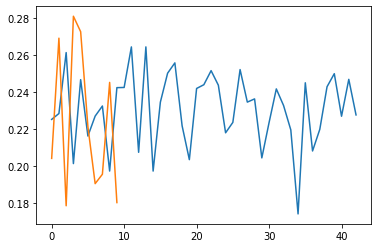

In [47]:
train_loss,test_loss=train_test(Net,None,opt,300,50,50,False,0,0,0)

In [48]:
sum(test_loss)/len(test_loss)

0.22380497604608535

In [21]:
# optimization loop
# running hyper parameter tuning using bayesian optimization
def optimize_hp(epochs):
    b_optimizer = BayesianOptimization(
        f=None,
        pbounds={'alpha':(0.05,0.1),'batch_size': (200, 500), 'random_factor': (10,100),'layer_size':(30,100),'drop1':(0,0.5),'drop2':(0,0.5),'drop3':(0,0.5)},
        verbose=2,
        random_state=1,
    )
    utility = UtilityFunction(kind="ucb", kappa=2.5, xi=0.0)
    # next params to try suggested by the algorithm
    for e in range(epochs):
        with open("preds.txt","w") as f:
            f.write("")
        with open("test_preds.txt","w") as f:
            f.write("")
        next_point = b_optimizer.suggest(utility)
        Net = DNN(int(next_point['layer_size']),next_point['drop1'],next_point['drop2'],next_point['drop3'])
        Net.years=Net.zero_pad(10)
        Net.mat_df = pd.io.parsers.read_csv('./data/matrix_small.csv',index_col=[0]).fillna(0)
        opt = torch.optim.Adam(Net.parameters(),lr=next_point['alpha'])
        losses = train(None,opt,Net,1,next_point['alpha'],int(next_point['layer_size']),int(next_point['batch_size']),int(next_point['random_factor']),False,next_point['drop1'],next_point['drop2'],next_point['drop3'])
        test_losses = test(Net,1,int(next_point['layer_size']),int(next_point['batch_size']),int(next_point['random_factor']))
        target = sum(test_losses)/len(test_losses)
        target= 1/target
        b_optimizer.register(params=next_point, target=target)
        print("end of epoch #",e+1," ",sum(test_losses)/len(test_losses))
    print(b_optimizer.max)

In [22]:
optimize_hp(3)

KeyboardInterrupt: 

In [76]:
def predict(Net,user_index,random_factor = 10):
    losses = []
    recoms = []
    targets = []
    all_targets = []
    results = []
    batch_input = []
    batch_w = []
    Net.eval()
    Net.train(False)
    Net.categories_embeddings=np.nan_to_num(Net.categories_embeddings)
    start = perf_counter()
    collaborative_embeddings,item_ids=MatrixFactorization.recommend_embeddings(user_index,U_s,V_s_t,factorizer.mat_df,factorizer.rank,random_factor)
    utils.shuffle_unision(collaborative_embeddings,item_ids)
    loss_fn = nn.BCELoss()
    user_id = factorizer.mat_df.index[user_index]
    user_em = U[user_index]
    
    for i in range(len(item_ids)):
        item_id = item_ids[i]
        col_em = collaborative_embeddings[i]
        cat_id = movies[movies['movieId']==item_id].index[0]
        cat_em = Net.categories_embeddings[cat_id]
        year_id = Net.data[Net.data['movieId']==item_id].values[0][0]
        year_em = Net.years[year_id]
        tags_title_em = Net.tags_titles_embeddings[cat_id]
        nn_input = []
        w_input = []
        nn_input.extend(col_em)
        nn_input.extend(user_em)
        side_features=get_item_features(item_id,tags_title_doc_lsi,genres_doc_lsi,Net.tags_titles_dict,movies).tolist()
        w_input.extend(year_em)

        nn_input.extend(side_features)

        if(len(nn_input)+len(w_input)==60):
            batch_input.append(nn_input)
            batch_w.append(w_input)
            with torch.no_grad():
                batch_input_t = torch.Tensor(batch_input)
                batch_w_t = torch.Tensor(batch_w)
                result = Net(batch_input_t,batch_w_t)
                results.append(result.tolist())
                recoms.append(result)
                batch_input = []
                target = [1] if mat_df[item_id][user_index]>=3 else [0]
                all_targets.append(target)
                batch_w = []
                targets = []
        
        else:
            print("Unacceptable input size of ",len(nn_input))
            print(cat_id)
    
    end = perf_counter()
    print("in ",end-start," seconds")
    return recoms,results,losses,item_ids,all_targets

In [81]:
def recommend_for_user(userId):
    recoms,results,pred_losses,item_ids_dnn,targets = predict(Net,userId,10)
    print(targets)
    e,item_ids_col=MatrixFactorization.recommend_embeddings(userId,U_s,V_s_t,factorizer.mat_df,factorizer.rank,3)
    item_ids = []
    for movie in range(len(factorizer.mat_df.iloc[userId])):
        if (factorizer.mat_df.iloc[userId,movie]>=3):
            item_ids_cb=MatrixFactorization.get_similar_items(movie,V.T)
            item_ids_cat = MatrixFactorization.get_similar_items(movie,np.array(Net.categories_embeddings))
            print(movies[movies["movieId"]==int(factorizer.mat_df.iloc[userId].index[movie])])
    print("##############")

    recoms_dict = dict(enumerate(recoms))
    sorted_recoms = {p: v for p, v in sorted(recoms_dict.items(), key=lambda item: item[1],reverse=True)}

    # getting 10 best recoms (movieIds)
    final_recoms = []
    i = 0
    for x in sorted_recoms:
        if(i==10):
            break
        final_recoms.append(item_ids_dnn[x])
        i+=1
    print(final_recoms)

    item_ids = item_ids_col+final_recoms+item_ids_cb+item_ids_cat
    item_ids=pd.unique(item_ids)
    np.random.shuffle(item_ids)
    for m_id in item_ids_col:
        print(movies[movies["movieId"]==m_id])

in  0.7056045999997878  seconds
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]


KeyError: (0, 9498)